In [2]:

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display


In [3]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b


tools = [multiply, add, divide]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

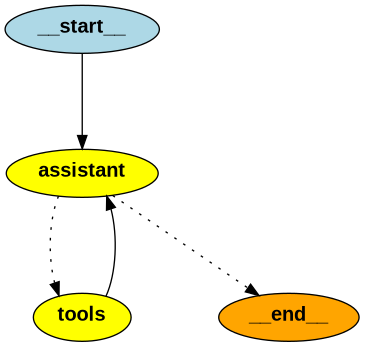

In [4]:
system_message = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([system_message] + state["messages"])]}

builder = StateGraph(MessagesState)

builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

display(Image(graph.get_graph().draw_png()))

In [5]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

config = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, config, stream_mode="values"):
    event['messages'][-1].pretty_print()


================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_L8LQFC2MFkAvU7avxs9RPvN0)
 Call ID: call_L8LQFC2MFkAvU7avxs9RPvN0
  Args:
    a: 2
    b: 3


In [6]:
state = graph.get_state(config)
state.next

('tools',)

In [7]:
for event in graph.stream(None, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  multiply (call_L8LQFC2MFkAvU7avxs9RPvN0)
 Call ID: call_L8LQFC2MFkAvU7avxs9RPvN0
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


In [8]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

config = {"configurable": {"thread_id": "2"}}

for event in graph.stream(initial_input, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

user_approval = input("Do you want to call the tool? (yes/no): ")

if user_approval.lower() == "yes":
    for event in graph.stream(None, config, stream_mode="values"):
        event['messages'][-1].pretty_print()
else:
    print("Operation cancelled by user.")

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_hN05XF7RD7MXUI0MKmkDdDQ5)
 Call ID: call_hN05XF7RD7MXUI0MKmkDdDQ5
  Args:
    a: 2
    b: 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_hN05XF7RD7MXUI0MKmkDdDQ5)
 Call ID: call_hN05XF7RD7MXUI0MKmkDdDQ5
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.
